In [0]:
import os
import pathlib
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline

In [0]:
# check if cuda is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print("Training on CPU")
else:
  print("Training on GPU")

Training on GPU


In [0]:
train_data_path = "drive/My Drive/dataset/intel/seg_train/seg_train"
test_data_path = "drive/My Drive/dataset/intel/seg_test/seg_test"
pred_path = "drive/My Drive/dataset/intel/seg_pred/seg_pred"

In [0]:
data_transform = transforms.Compose([transforms.Resize((150,150)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

train_data = datasets.ImageFolder(train_data_path , transform = data_transform)

test_data = datasets.ImageFolder(test_data_path, transform  = data_transform)

In [0]:
val_size = 0.2
batch_size = 128
num_workers = 0


# Create validation set
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(val_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size, 
                                           sampler = train_sampler,
                                           num_workers = num_workers)


val_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                         sampler = valid_sampler,
                                         num_workers = num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

In [0]:
class Classifier(nn.Module):

  def __init__(self):
    super(Classifier, self).__init__()

    self.conv1 = nn.Conv2d(in_channels= 3, out_channels= 16, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size= 3, padding = 1)
    self.conv3 = nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size = 3, padding = 1)
    self.conv4 = nn.Conv2d(in_channels = 64, out_channels= 128, kernel_size= 3, padding = 1)
    self.conv5 = nn.Conv2d(in_channels= 128, out_channels= 256, kernel_size= 3, padding = 1)

    self.pool = nn.MaxPool2d(kernel_size= 2, stride= 2)
    self.dropout = nn.Dropout(p = 0.2)

    self.fc1 = nn.Linear(in_features= 4*4*256 , out_features= 1024 )
    self.fc2 = nn.Linear(in_features= 1024 , out_features= 512 )
    self.fc3 = nn.Linear(in_features= 512, out_features= 6)

  
  def forward(self, x):

    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout(x)
    x = self.pool(F.relu(self.conv3(x)))
    x = self.pool(F.relu(self.conv4(x)))
    x = self.dropout(x)
    x = self.pool(F.relu(self.conv5(x)))

    x = x.view(x.size(0), -1)

    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.relu(self.fc3(x))

    return x

In [0]:
model = Classifier()
print(model)

if train_on_gpu:
  model.cuda()

Classifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=6, bias=True)
)


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [0]:
n_epochs = 30
val_loss_min = np.Inf
step = 0
training_loss = []
validation_loss = []

for e in range(n_epochs):
  train_loss = 0
  val_loss = 0

  start_time = time.time()
  total_train_loss = 0

#-----------------
# TRAINING MODEL  
#-----------------

  model.train()
  for img, label in train_loader:
    # move tensor to gpu
    if train_on_gpu:
      img, label = img.cuda(), label.cuda()


    optimizer.zero_grad()
    output = model(img)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()*img.size(0)

    if step % 10 == 0:
      print("Step {} is in progress...".format(step))
  
    step += 1


#-------------
# Validation
#-------------

  model.eval()
  for img, label in val_loader:

    if train_on_gpu:
      img, label = img.cuda(), label.cuda()

    output = model(img)
    loss = criterion(output, label)
    
    val_loss += loss.item()*img.size(0)

  train_loss = train_loss / len(train_loader.sampler)
  val_loss = val_loss / len(val_loader.sampler)
  
  # append loss 
  training_loss.append(train_loss)
  validation_loss.append(val_loss)

  print("Epoch: {}  \tTraining Loss: {:.4f}  \tValidation Loss: {:.4f}  \ttook: {:.2f}s".format(e, train_loss, val_loss, time.time() - start_time))

  if val_loss <= val_loss_min:
    print("Validation Loss Decreased from: {:.4f} -----> {:.4f}  \tSaving Model.... ".format(val_loss_min, val_loss))
    torch.save(model.state_dict(), "drive/My Drive/dataset/intel/model.pt")
    val_loss_min = val_loss

  start_time = time.time()


Step 0 is in progress...
Step 10 is in progress...
Step 20 is in progress...
Step 30 is in progress...
Step 40 is in progress...
Step 50 is in progress...
Step 60 is in progress...
Step 70 is in progress...
Step 80 is in progress...
Epoch: 0  	Training Loss: 1.4720  	Validation Loss: 1.2696  	took: 7075.89s
Validation Loss Decreased from: inf -----> 1.2696  	Saving Model.... 
Step 90 is in progress...
Step 100 is in progress...
Step 110 is in progress...
Step 120 is in progress...
Step 130 is in progress...
Step 140 is in progress...
Step 150 is in progress...
Step 160 is in progress...
Step 170 is in progress...
Epoch: 1  	Training Loss: 1.2265  	Validation Loss: 1.1752  	took: 45.29s
Validation Loss Decreased from: 1.2696 -----> 1.1752  	Saving Model.... 
Step 180 is in progress...
Step 190 is in progress...
Step 200 is in progress...
Step 210 is in progress...
Step 220 is in progress...
Step 230 is in progress...
Step 240 is in progress...
Step 250 is in progress...
Step 260 is in p

In [0]:
model.load_state_dict(torch.load("drive/My Drive/dataset/intel/model.pt"))

<All keys matched successfully>

In [0]:
# Get the classes
import pathlib
root = pathlib.Path('drive/My Drive/dataset/intel/seg_train/seg_train')
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [0]:
batch_size = 128

pred_transform = transforms.Compose([transforms.Resize((150,150)),
                                     transforms.ToTensor()])


load_data = datasets.ImageFolder('drive/My Drive/dataset/intel/seg_pred',transform = pred_transform)

data = torch.utils.data.DataLoader(load_data , batch_size= batch_size)


In [0]:
X_pred, y_pred = next(iter(data))
print(X_pred.size())

if train_on_gpu:
      X_pred, y_pred = X_pred.cuda(), y_pred.cuda()


output = model(X_pred)
_, pred = torch.max(output , 1)

X_pred, y_pred = X_pred.cpu(), y_pred.cpu()

print(pred)


torch.Size([128, 3, 150, 150])
tensor([2, 3, 5, 2, 2, 2, 4, 2, 4, 2, 4, 5, 3, 5, 2, 2, 1, 1, 2, 3, 5, 2, 2, 2,
        2, 2, 2, 3, 2, 3, 3, 4, 3, 4, 2, 3, 2, 2, 3, 3, 2, 2, 2, 4, 2, 2, 4, 4,
        3, 2, 2, 3, 1, 4, 2, 2, 2, 2, 3, 5, 2, 1, 2, 0, 2, 3, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 4, 2, 2, 2, 5, 2, 2, 1, 1, 3, 2, 2, 2, 5, 3, 3, 2, 2, 2, 0,
        4, 2, 2, 2, 2, 5, 2, 4, 1, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 4, 5, 2, 4, 3,
        3, 4, 2, 3, 5, 2, 0, 2], device='cuda:0')


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
  '''
  Function to un-normalize and display an image
  '''
  img = img/2 + 0.5 # un-normalize
  plt.imshow(np.transpose(img, (1, 2, 0))) # convert from tensor image


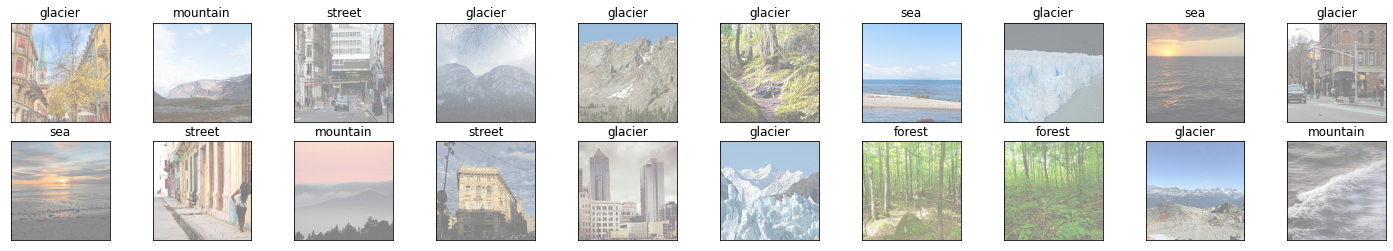

In [0]:
# Visualize predicted labels
fig = plt.figure(figsize = (25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx + 1, xticks = [], yticks = [])
  imshow(X_pred[idx])
  ax.set_title('{}'.format(classes[pred[idx]]))

In [0]:
print(classes)
print(pred)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tensor([2, 3, 5, 2, 2, 2, 4, 2, 4, 2, 4, 5, 3, 5, 2, 2, 1, 1, 2, 3, 5, 2, 2, 2,
        2, 2, 2, 3, 2, 3, 3, 4, 3, 4, 2, 3, 2, 2, 3, 3, 2, 2, 2, 4, 2, 2, 4, 4,
        3, 2, 2, 3, 1, 4, 2, 2, 2, 2, 3, 5, 2, 1, 2, 0, 2, 3, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 4, 2, 2, 2, 5, 2, 2, 1, 1, 3, 2, 2, 2, 5, 3, 3, 2, 2, 2, 0,
        4, 2, 2, 2, 2, 5, 2, 4, 1, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 4, 5, 2, 4, 3,
        3, 4, 2, 3, 5, 2, 0, 2], device='cuda:0')


<function matplotlib.pyplot.show>

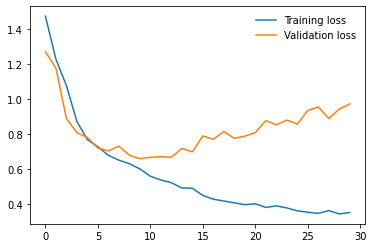

In [0]:
plt.plot(training_loss, label = 'Training loss')
plt.plot(validation_loss, label = 'Validation loss')
plt.legend(frameon = False)
plt.show


In [0]:
test_loss = 0
correct_cls = list(0. for i in range(len(classes)))
total_cls = list(0. for i in range(len(classes)))

In [0]:
model.eval()
for img, label in test_loader:
  if train_on_gpu:
    img , label = img.cuda(), label.cuda()

  output = model(img)
  loss = criterion(output, label)

  test_loss += loss.item()*img.size(0)
  _, pred = torch.max(output, 1)

  correct_pred = pred.eq(label.view_as(pred))
  correct = np.sequeeze(correct_pred.numpy()) if not train_on_gpu else np.squeeze(correct_pred.cpu().numpy())

  for i in range(10):
    target = label.data[i]
    correct_cls[target] += correct[i].item()
    total_cls[target] += 1
  

test_loss = test_loss / len(test_loader.dataset)
print("Test Loss: {:.4f}".format(test_loss))

for i in range(6):
  if total_cls[i] > 0:
    print('Test accuracy of %5s: %2d%% (%2d/%2d)' % (
          classes[i], 100*correct_cls[i] / total_cls[i], 
          np.sum(correct_cls[i]), np.sum(total_cls[i])))
  else:
    print('Test accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest accuracy (Overall): %2d%% (%2d/%2d)' % (
    100.*np.sum(correct_cls)/ np.sum(total_cls),
    np.sum(correct_cls), np.sum(total_cls)))

Test Loss: 0.6523
Test accuracy of buildings: 75% (75/100)
Test accuracy of forest: 97% (78/80)
Test accuracy of glacier: 90% (72/80)
Test accuracy of mountain: 87% (70/80)
Test accuracy of   sea: 77% (62/80)
Test accuracy of street: 90% (72/80)

Test accuracy (Overall): 85% (429/500)
